<a href="https://colab.research.google.com/github/carlaprv/sin5007-reconhecimento-de-padroes/blob/master/k_fold_cross_validation_%2B_Naive_Bayes%2BSVM%2BRedes_Neurais_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/carlaprv/sin5007-reconhecimento-de-padroes cloned-repo
%cd cloned-repo
!ls

# Naive Bayes + SVM + Redes Neurais
-------------------------------------------------------------------------------------------------------------

# Bibliotecas Necessárias

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import seaborn as sns # visualize
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from statsmodels.stats.weightstats import DescrStatsW
import warnings
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Funções Auxiliares

describe_dataset() : realiza o cálculo das proporções de classes do dataset original

In [3]:
def describe_dataset(X, y, k):
    # get dataset rows: instances , columns: features
    rows, columns = X.shape
    # get proportion from target
    (unique, counts) = np.unique(y, return_counts=True) 
    # calculate proportion
    prop_neg = int(counts[0]/rows*100)
    prop_pos = int(counts[1]/rows*100)

    print("k = {}, Dataset: {} positivas, {} negativas ({}% x {}%)".format(k, counts[1], counts[0], prop_pos, prop_neg))
    print("")

get_classes_from_index() : realiza o cálculo das proporções de classes dos folds criados

In [4]:
def get_classes_from_index(y, skf):
    _, y_idx, y_inv = np.unique(y, return_index=True, return_inverse=True)
    y_counts = np.bincount(y_inv)
    _, class_perm = np.unique(y_idx, return_inverse=True)
    y_encoded = class_perm[y_inv]
    y_order = np.sort(y_encoded)
    n_classes = len(y_idx)
    allocation = np.asarray(
            [np.bincount(y_order[i::skf.n_splits], minlength=n_classes)
             for i in range(skf.n_splits)])

    for idx, f in enumerate(allocation):
        count_neg = int(f[0])
        count_pos = int(f[1])
        total = count_neg+count_pos
        prop_temp_neg = int(count_neg/total*100)
        prop_temp_pos = int(count_pos/total*100)
        print("Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {}% x {}%".format(idx, count_pos, count_neg, total, prop_temp_pos, prop_temp_neg))
    print("")

get_ic(): realiza o cálculo do indice de confiança

In [5]:
def get_ic(data, alpha):
    
    mean_c = []
    for ic in lista_result:
        
        c = result[0]
        result_c = result[1]
        
        # Calcula a média das medidas do parametro c
        precision_mean = result_c['precision'].mean()
        recall_mean = result_c['recall'].mean()
        f1_score_mean = result_c['f1-score'].mean()
        support_mean = result_c['support'].mean()
        accuracy_mean = result_c['accuracy'].mean()

        # Calcula as ic das medidas
        precision_ic = sms.DescrStatsW(result_c['precision']).tconfint_mean(alpha)
        recall_ic = sms.DescrStatsW(result_c['recall']).tconfint_mean(alpha)
        f1_score_ic = sms.DescrStatsW(result_c['f1-score']).tconfint_mean(alpha)
        support_ic = sms.DescrStatsW(result_c['support']).tconfint_mean(alpha)
        accuracy_ic = sms.DescrStatsW(result_c['accuracy']).tconfint_mean(alpha)

        ic = {'recall_ic' : recall_ic, 'support_ic' : support_ic, 'accuracy_ic': accuracy_ic }
        ic = pd.DataFrame(ic, index=['inf','sup'])

        # Armazena a média das medidas do parametro c
        mean_c.append([c, precision_mean, recall_mean, f1_score_mean, support_mean, accuracy_mean])
    
    name_columns = ['c', 'precision_mean', 'recall_mean', 'f1_score_mean', 'support_mean', 'accuracy_mean']
    mean_c = pd.DataFrame(mean_c, columns=name_columns)
    return mean_c, ic

In [6]:
def get_ic(data, alpha):

    # Calcula as ic das medidas
    accuracy_ic_inf, accuracy_ic_sup = sms.DescrStatsW(data['accuracy']).tconfint_mean(alpha)
    precision_ic_inf, precision_ic_sup = sms.DescrStatsW(data['precision']).tconfint_mean(alpha)
    recall_ic_inf, recall_ic_sup = sms.DescrStatsW(data['recall']).tconfint_mean(alpha)
    fscore_ic_inf, fscore_ic_sup = sms.DescrStatsW(data['fscore']).tconfint_mean(alpha)
    
    ic = [accuracy_ic_inf, accuracy_ic_sup, precision_ic_inf, precision_ic_sup, recall_ic_inf, recall_ic_sup, fscore_ic_inf, fscore_ic_sup]

    return ic

In [7]:
def Classifier_grid(X, y, k, parameters_in , Classifier, dataSet):
     
    """
    Parameters
    ----------    
              X: array-like, shape (n_samples, n_features) -- Training data, where n_samples is the number of samples and n_features is the number of features.
              y: array-like, of length n_samples  -- The target variable for supervised learning problems.
              k: int -- Determines the number of folds.
        dataSet: method selection (string)
  parameters_in: all parameters (tuple)

    """
    ### Estratifica o dataset em k folds
    skf = StratifiedKFold(n_splits=k)
    describe_dataset(X, y, k)
    get_classes_from_index(y, skf) 

    ### ParameterGrid
    list_parameters = ParameterGrid(parameters_in)
       
    #################################################################################################################
    # 1. Classifier 
    #################################################################################################################
    result = []
    result_ic = []
    result_k = []
    result_best = []

    total_p = len(list_parameters)
    print("---")
    print('Quantidade de parametros:', total_p)
    p=1
    for P in list_parameters:
        print('Parametro:',p,'/',total_p)
        print(P)

        ### resultado do fold-k
        clf = Classifier(**P)

        fold_k = 1
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            ### Train the model
            clf.fit(X_train, y_train)
    
            ### Test the model
            y_predicted = clf.predict(X_test)
            
            ### calculate metrics
            report_dict = metrics.classification_report(y_test, y_predicted, output_dict=True)
            report_str = metrics.classification_report(y_test, y_predicted)        
            ### print(report_str)
            
            all_metrics = precision_recall_fscore_support(y_true=y_test, y_pred=y_predicted, average='weighted')
            accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_predicted)
            precision = all_metrics[0]
            recall = all_metrics[1]
            fscore = all_metrics[2]
                        
            ### Armazena o resultado do fold k
            r = [Classifier.__name__, dataSet, fold_k, accuracy ,  precision,  recall , fscore] + list(P.values())
            result_k.append(r)
            #print(result_k)
            fold_k = fold_k + 1
            
    
        columns_r = [Classifier.__name__,'Dataset', 'fold', 'accuracy','precision','recall','fscore'] + list(P.keys())
        p=p+1
        result_k = pd.DataFrame(result_k, columns=columns_r)

        ### calcula a média das métricas dos k-folds      
        accuracy_avg = result_k['accuracy'].mean()
        precision_avg = result_k['precision'].mean()
        recall_avg = result_k['recall'].mean()
        fscore_avg = result_k['fscore'].mean()
        
        ### Calcula o índice de confiança dos k-folds
        alpha = 0.05
        ic_c = [dataSet] + list(get_ic(result_k, alpha))
        
        ### Armazena a média dos resultados dos k-folds e o índice de confiança
        result.append([Classifier.__name__,dataSet, accuracy_avg, precision_avg, recall_avg, fscore_avg] + list(P.values())) 
        result_ic.append(list(ic_c) + list(P.values()))
        result_k = []

    
    ### Exibe a media dos resultados de cada valor
    columns_avg = ['Classifier', 'dataSet','accuracy_avg','precision_avg','recall_avg','fscore_avg'] + list(P.keys())
    result = pd.DataFrame(result, columns=columns_avg)

      
    columns_ic = ['dataSet','accuracy_ic_inf','accuracy_ic_sup','precision_ic_inf','precision_ic_sup','recall_ic_inf', 'recall_ic_sup','fscore_ic_inf', 'fscore_ic_sup'] + list(P.keys())
    result_ic = pd.DataFrame(result_ic, columns=columns_ic)
    #print("Média dos resultados")
    #print(result)
    #print(result_ic)
    #print("")
        
    #################################################################################################################
    ### ARMAZENA OS MELHORES RESULTADOS 
    #################################################################################################################
    
    ### Armazena apenas as métricas da melhor acurácia média do MODELO e o seu indice de confiança
  
    result_best = pd.DataFrame(result.iloc[[result['accuracy_avg'].argmax()]])
    print(result_best)
   
    ic_best = pd.DataFrame(result_ic.iloc[[result['accuracy_avg'].argmax()]])
    print(ic_best)
    
    return result_best, ic_best 

# 1. Naive Bayes


##### Parâmetros de execução do Naive Bayes
* list_c : valores do parâmetro de ajuste de probabilidade 

* k_folds : número de folds para a estratificação do dataset

In [8]:
list_c = [0.001, 0.10, 0.25, 0.50, 0.75, 1]
k_folds = 10


### 1.1. Naive Bayes: All Features

In [9]:
df = pd.read_csv('results/dataset-normalizado.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
parameters_in = {'var_smoothing': [0.001, 0.10, 0.25, 0.50, 0.75, 1]}

result_NB_all, ic_NB_all = Classifier_grid(X, y, k_folds, parameters_in, GaussianNB, dataSet='All Features')
print("Melhor resultado:")
result_NB_all

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

---
Quantidade de parametros: 6
Parametro: 1 / 6
{'var_smoothing': 0.001}
Parametro: 2 / 6
{'var_smoothing': 0.1}
Parametro: 3 / 6
{'var_smoothing': 0.25}
Parametro: 4 / 6
{'var_smoothing': 0.5}
Parametro: 5 / 6
{'var_smoothing': 0.75}
Parametro: 6 / 6
{'var_smoothing': 1}
   Classifier       dataSet  ...  fscore_avg  var_smoothing
1  GaussianNB  All Feature

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,var_smoothing
1,GaussianNB,All Features,0.71488,0.739373,0.71488,0.700049,0.1


Índice de Confiança do melhor resultado

In [10]:
ic_NB_all

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,var_smoothing
1,All Features,0.647212,0.782547,0.686647,0.792099,0.647212,0.782547,0.619341,0.780758,0.1


### 1.2. Naive Bayes: PCA

In [11]:
df = pd.read_csv('results/dataset-pca.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
parameters_in = {'var_smoothing': [0.001, 0.10, 0.25, 0.50, 0.75, 1]}

result_NB_pca, ic_NB_pca = Classifier_grid(X, y, k_folds, parameters_in, GaussianNB, dataSet='PCA')
print("Melhor resultado:")
result_NB_pca

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

---
Quantidade de parametros: 6
Parametro: 1 / 6
{'var_smoothing': 0.001}
Parametro: 2 / 6
{'var_smoothing': 0.1}
Parametro: 3 / 6
{'var_smoothing': 0.25}
Parametro: 4 / 6
{'var_smoothing': 0.5}
Parametro: 5 / 6
{'var_smoothing': 0.75}
Parametro: 6 / 6
{'var_smoothing': 1}
   Classifier dataSet  accuracy_avg  ...  recall_avg  fscore_avg  var_smoothing
3  Gau

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,var_smoothing
3,GaussianNB,PCA,0.687188,0.73557,0.687188,0.650919,0.5


Índice de Confiança

In [12]:
ic_NB_pca

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,var_smoothing
3,PCA,0.615426,0.758949,0.679282,0.791858,0.615426,0.758949,0.548533,0.753306,0.5


### 1.3. Naive Bayes: Chi Squared (K-Best)

In [13]:
df = pd.read_csv('results/dataset-fs-chi-squared.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
parameters_in = {'var_smoothing': [0.001, 0.10, 0.25, 0.50, 0.75, 1]}
result_NB_chi, ic_NB_chi = Classifier_grid(X, y, k_folds, parameters_in, GaussianNB, dataSet='CHI')
print("Melhor resultado:")
result_NB_chi

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

---
Quantidade de parametros: 6
Parametro: 1 / 6
{'var_smoothing': 0.001}
Parametro: 2 / 6
{'var_smoothing': 0.1}
Parametro: 3 / 6
{'var_smoothing': 0.25}
Parametro: 4 / 6
{'var_smoothing': 0.5}
Parametro: 5 / 6
{'var_smoothing': 0.75}
Parametro: 6 / 6
{'var_smoothing': 1}
   Classifier dataSet  accuracy_avg  ...  recall_avg  fscore_avg  var_smoothing
0  Gau

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,var_smoothing
0,GaussianNB,CHI,0.741058,0.768852,0.741058,0.726894,0.001


Índice de Confiança para o dataset Chi-Squared

In [14]:
ic_NB_chi

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,var_smoothing
0,CHI,0.673445,0.80867,0.714899,0.822804,0.673445,0.80867,0.645429,0.808358,0.001


### 1.4. Naive Bayes: Recursive Feature

In [15]:
df = pd.read_csv('results/dataset-fs-recursive-feature.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
parameters_in = {'var_smoothing': [0.001, 0.10, 0.25, 0.50, 0.75, 1]}
result_NB_rf, ic_NB_rf = Classifier_grid(X, y, k_folds, parameters_in, GaussianNB, dataSet='Recursive')
result_NB_rf

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

---
Quantidade de parametros: 6
Parametro: 1 / 6
{'var_smoothing': 0.001}
Parametro: 2 / 6
{'var_smoothing': 0.1}
Parametro: 3 / 6
{'var_smoothing': 0.25}
Parametro: 4 / 6
{'var_smoothing': 0.5}
Parametro: 5 / 6
{'var_smoothing': 0.75}
Parametro: 6 / 6
{'var_smoothing': 1}
   Classifier    dataSet  accuracy_avg  ...  recall_avg  fscore_avg  var_smoothing
0  

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,var_smoothing
0,GaussianNB,Recursive,0.731875,0.762049,0.731875,0.715121,0.001


Índice de Confiança para dataset Recursive-Feature

In [16]:
ic_NB_rf

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,var_smoothing
0,Recursive,0.666579,0.797171,0.708537,0.815561,0.666579,0.797171,0.633364,0.796879,0.001


# 2. SVM

##### Parâmetros de execução do SVM

* k_folds:     número de folds para a estratificação do dataset

* list_c:      valores do parâmetro de ajuste de probabilidade 

* list_degree: valores do parâmetro degree utilizado no kernel poly

* list_gamma:  valores do parâmetro gamma utilizado no kernel poly

* list_coef:   valores do parâmetro coef utilizado no kernel rbf

* Função que aplica o SVM para cada Kernel implementado
* Em cada kernel é testado vários valores de cada parâmetro.
* Com o resultado de cada parâmetro, verifica qual a melhor acurácia.

In [17]:
# list_c = [0.001, 0.10, 0.25, 0.50, 0.75, 1]
list_c = [0.001, 0.10]
list_gamma = [0.001, 0.1, 0.5, 1]
list_degree = [1, 2, 3, 4, 5]

list_coef = [0.01]

### 2.1. SVM: all features

In [18]:
df = pd.read_csv('results/dataset-normalizado.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target

list_kernel = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in list_kernel:
  print(kernel)
  parameters_in = {'C': [0.001, 0.10],
                 'kernel': [kernel],
                 'degree': [1, 2, 3, 4, 5],
                 'gamma' : [0.001, 0.1, 0.5, 1]}
  exec("SVM_{i}_all, SVM_{i}_ic_all = Classifier_grid(X, y, k_folds, parameters_in, svm.SVC, dataSet='All Features')".format(i=kernel))


linear
k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

---
Quantidade de parametros: 40
Parametro: 1 / 40
{'C': 0.001, 'degree': 1, 'gamma': 0.001, 'kernel': 'linear'}
Parametro: 2 / 40
{'C': 0.001, 'degree': 1, 'gamma': 0.1, 'kernel': 'linear'}
Parametro: 3 / 40
{'C': 0.001, 'degree': 1, 'gamma': 0.5, 'kernel': 'linear'}
Parametro: 4 / 40
{'C': 0.001, 'degree': 1, 'gamma': 1, 'kernel': 'linear'}
Parametr

In [19]:
# Exibe o resultado do kernel Linear
SVM_linear_all


,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,C,degree,gamma,kernel
20,SVC,All Features,0.697909,0.754553,0.697909,0.670648,0.1,1,0.001,linear


In [20]:
SVM_linear_ic_all

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,C,degree,gamma,kernel
20,All Features,0.625931,0.769886,0.702986,0.80612,0.625931,0.769886,0.58007,0.761227,0.1,1,0.001,linear


In [21]:
# Exibe o resultado do kernel Polynomial
SVM_poly_all

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,C,degree,gamma,kernel
11,SVC,All Features,0.71024,0.731985,0.71024,0.696639,0.001,3,1.0,poly


In [22]:
SVM_poly_ic_all


,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,C,degree,gamma,kernel
11,All Features,0.634177,0.786304,0.664784,0.799185,0.634177,0.786304,0.611885,0.781393,0.001,3,1.0,poly


In [23]:
# Exibe o resultado do Kernel RBF
SVM_rbf_all

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,C,degree,gamma,kernel
21,SVC,All Features,0.673341,0.70829,0.673341,0.635024,0.1,1,0.1,rbf


In [24]:
SVM_rbf_ic_all

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,C,degree,gamma,kernel
21,All Features,0.604949,0.741734,0.633665,0.782914,0.604949,0.741734,0.53965,0.730398,0.1,1,0.1,rbf


### 2.2. SVM: PCA

In [25]:

df = pd.read_csv('results/dataset-pca.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
list_kernel = ['linear', 'poly', 'rbf', 'sigmoid']

for ker in list_kernel:
  print(ker)
  parameters_in = {'C': [0.001, 0.10],
                 'kernel': [ker],
                 'degree': [1, 2, 3, 4, 5],
                 'gamma' : [0.001, 0.1, 0.5, 1]}
  exec("SVM_{i}_pca, SVM_{i}_ic_pca = Classifier_grid(X, y, k_folds, parameters_in, svm.SVC, dataSet='PCA')".format(i=ker))

linear
k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

---
Quantidade de parametros: 40
Parametro: 1 / 40
{'C': 0.001, 'degree': 1, 'gamma': 0.001, 'kernel': 'linear'}
Parametro: 2 / 40
{'C': 0.001, 'degree': 1, 'gamma': 0.1, 'kernel': 'linear'}
Parametro: 3 / 40
{'C': 0.001, 'degree': 1, 'gamma': 0.5, 'kernel': 'linear'}
Parametro: 4 / 40
{'C': 0.001, 'degree': 1, 'gamma': 1, 'kernel': 'linear'}
Parametr

In [26]:
# Exibe o resultado do kernel Linear
SVM_linear_pca

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,C,degree,gamma,kernel
20,SVC,PCA,0.699495,0.738248,0.699495,0.675761,0.1,1,0.001,linear


In [27]:
SVM_linear_ic_pca

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,C,degree,gamma,kernel
20,PCA,0.62453,0.77446,0.678692,0.797804,0.62453,0.77446,0.582293,0.769229,0.1,1,0.001,linear


In [28]:
# Exibe o resultado do kernel poly
SVM_poly_pca

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,C,degree,gamma,kernel
22,SVC,PCA,0.700937,0.734984,0.700937,0.676787,0.1,1,0.5,poly


In [29]:
SVM_poly_ic_pca

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,C,degree,gamma,kernel
22,PCA,0.624257,0.777618,0.673032,0.796937,0.624257,0.777618,0.580924,0.77265,0.1,1,0.5,poly


In [30]:
# Exibe o resultado do kernel rbf
SVM_rbf_pca

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,C,degree,gamma,kernel
21,SVC,PCA,0.684111,0.70368,0.684111,0.654902,0.1,1,0.1,rbf


In [31]:
SVM_rbf_ic_pca

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,C,degree,gamma,kernel
21,PCA,0.602005,0.766217,0.615024,0.792336,0.602005,0.766217,0.54928,0.760524,0.1,1,0.1,rbf


### 2.3. SVM: Chi Squared (k-Best)

In [32]:
df = pd.read_csv('results/dataset-fs-chi-squared.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target

list_kernel = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in list_kernel:
  print(kernel)
  parameters_in = {'C': [0.001, 0.10],
                 'kernel': [kernel],
                 'degree': [1, 2, 3, 4, 5],
                 'gamma' : [0.001, 0.1, 0.5, 1]}
  exec("SVM_{i}_chi, SVM_{i}_ic_chi = Classifier_grid(X, y, k_folds, parameters_in, svm.SVC, dataSet='CHI')".format(i=kernel))

linear
k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

---
Quantidade de parametros: 40
Parametro: 1 / 40
{'C': 0.001, 'degree': 1, 'gamma': 0.001, 'kernel': 'linear'}
Parametro: 2 / 40
{'C': 0.001, 'degree': 1, 'gamma': 0.1, 'kernel': 'linear'}
Parametro: 3 / 40
{'C': 0.001, 'degree': 1, 'gamma': 0.5, 'kernel': 'linear'}
Parametro: 4 / 40
{'C': 0.001, 'degree': 1, 'gamma': 1, 'kernel': 'linear'}
Parametr

In [33]:
# Exibe o resultado do kernel Linear
SVM_linear_chi

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,C,degree,gamma,kernel
20,SVC,CHI,0.70101,0.744777,0.70101,0.671998,0.1,1,0.001,linear


In [34]:
SVM_linear_ic_chi

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,C,degree,gamma,kernel
20,CHI,0.612182,0.789837,0.675395,0.81416,0.612182,0.789837,0.563516,0.780479,0.1,1,0.001,linear


In [35]:
# Exibe o resultado do kernel Poly
SVM_poly_chi

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,C,degree,gamma,kernel
27,SVC,CHI,0.708726,0.74989,0.708726,0.682172,0.1,2,1.0,poly


In [36]:
SVM_poly_ic_chi

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,C,degree,gamma,kernel
27,CHI,0.630528,0.786924,0.686755,0.813026,0.630528,0.786924,0.584729,0.779615,0.1,2,1.0,poly


In [37]:
# Exibe o resultado do kernel RBF
SVM_rbf_chi

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,C,degree,gamma,kernel
21,SVC,CHI,0.711803,0.755496,0.711803,0.683179,0.1,1,0.1,rbf


In [38]:
SVM_rbf_ic_chi

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,C,degree,gamma,kernel
21,CHI,0.619454,0.804152,0.68169,0.829303,0.619454,0.804152,0.571175,0.795184,0.1,1,0.1,rbf


### 2.4. SVM: Recursive Feature

In [39]:
df = pd.read_csv('results/dataset-fs-recursive-feature.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
list_kernel = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in list_kernel:
  print(kernel)
  parameters_in = {'C': [0.001, 0.10],
                 'kernel': [kernel],
                 'degree': [1, 2, 3, 4, 5],
                 'gamma' : [0.001, 0.1, 0.5, 1]}
  exec("SVM_{i}_rf, SVM_{i}_ic_rf = Classifier_grid(X, y, k_folds, parameters_in, svm.SVC, dataSet='Recursive')".format(i=kernel))

linear
k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

---
Quantidade de parametros: 40
Parametro: 1 / 40
{'C': 0.001, 'degree': 1, 'gamma': 0.001, 'kernel': 'linear'}
Parametro: 2 / 40
{'C': 0.001, 'degree': 1, 'gamma': 0.1, 'kernel': 'linear'}
Parametro: 3 / 40
{'C': 0.001, 'degree': 1, 'gamma': 0.5, 'kernel': 'linear'}
Parametro: 4 / 40
{'C': 0.001, 'degree': 1, 'gamma': 1, 'kernel': 'linear'}
Parametr

In [40]:
# Exibe o resultado do kernel Linear
SVM_linear_rf

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,C,degree,gamma,kernel
20,SVC,Recursive,0.719423,0.770335,0.719423,0.690837,0.1,1,0.001,linear


In [41]:
SVM_linear_ic_rf

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,C,degree,gamma,kernel
20,Recursive,0.628961,0.809885,0.702988,0.837682,0.628961,0.809885,0.578864,0.802811,0.1,1,0.001,linear


In [42]:
# Exibe o resultado do kernel Poly
SVM_poly_rf

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,C,degree,gamma,kernel
23,SVC,Recursive,0.719423,0.770335,0.719423,0.690837,0.1,1,1.0,poly


In [43]:
SVM_poly_ic_rf

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,C,degree,gamma,kernel
23,Recursive,0.628961,0.809885,0.702988,0.837682,0.628961,0.809885,0.578864,0.802811,0.1,1,1.0,poly


In [44]:
# Exibe o resultado do kernel RBF
SVM_rbf_rf

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,C,degree,gamma,kernel
22,SVC,Recursive,0.703966,0.769364,0.703966,0.665968,0.1,1,0.5,rbf


In [45]:
SVM_rbf_ic_rf

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,C,degree,gamma,kernel
22,Recursive,0.608703,0.79923,0.711012,0.827715,0.608703,0.79923,0.542463,0.789474,0.1,1,0.5,rbf


# 3.Redes Neurais

##### Parâmetros de execução das Redes Neurais

* k_folds:     número de folds para a estratificação do dataset

* hidden_layer_sizes:      valores do parâmetro quantidades de neuronios camada oculta

* activation: Função de ativação

* learning_rate:  Taxa de aprendizado pesos

* max_iter:   Número maximo de iterações 





In [46]:
df = pd.read_csv('results/dataset-normalizado.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
parameters_in = {'activation': ['identity','logistic','tanh','relu'], # {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
                 'hidden_layer_sizes': [(56,56)], #default=(100,)
                 'learning_rate_init': [0.001, 0.01], #default=0.001
                 'max_iter':[1000]
                 }
RN_all,RN_all_ic = Classifier_grid(X, y, k_folds, parameters_in,MLPClassifier, dataSet='All Features')

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

---
Quantidade de parametros: 8
Parametro: 1 / 8
{'activation': 'identity', 'hidden_layer_sizes': (56, 56), 'learning_rate_init': 0.001, 'max_iter': 1000}
Parametro: 2 / 8
{'activation': 'identity', 'hidden_layer_sizes': (56, 56), 'learning_rate_init': 0.01, 'max_iter': 1000}
Parametro: 3 / 8
{'activation': 'logistic', 'hidden_layer_sizes': (56, 56), 'learni

In [47]:
df = pd.read_csv('results/dataset-pca.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
parameters_in = {'activation': ['identity','logistic','tanh','relu'], # {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
                 'hidden_layer_sizes': [(56,56)], #default=(100,)
                 'learning_rate_init': [0.001, 0.01], #default=0.001
                 'max_iter':[1000]
                 }
RN_pca,RN_pca_ic = Classifier_grid(X, y, k_folds, parameters_in,MLPClassifier, dataSet='PCA')

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

---
Quantidade de parametros: 8
Parametro: 1 / 8
{'activation': 'identity', 'hidden_layer_sizes': (56, 56), 'learning_rate_init': 0.001, 'max_iter': 1000}
Parametro: 2 / 8
{'activation': 'identity', 'hidden_layer_sizes': (56, 56), 'learning_rate_init': 0.01, 'max_iter': 1000}
Parametro: 3 / 8
{'activation': 'logistic', 'hidden_layer_sizes': (56, 56), 'learni

In [48]:
df = pd.read_csv('results/dataset-fs-recursive-feature.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
parameters_in = {'activation': ['identity','logistic','tanh','relu'], # {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
                 'hidden_layer_sizes': [(56,56)], #default=(100,)
                 'learning_rate_init': [0.001, 0.01], #default=0.001
                 'max_iter':[1000]
                 }
RN_rf,RN_rf_ic = Classifier_grid(X, y, k_folds, parameters_in,MLPClassifier, dataSet='Recursive')

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

---
Quantidade de parametros: 8
Parametro: 1 / 8
{'activation': 'identity', 'hidden_layer_sizes': (56, 56), 'learning_rate_init': 0.001, 'max_iter': 1000}
Parametro: 2 / 8
{'activation': 'identity', 'hidden_layer_sizes': (56, 56), 'learning_rate_init': 0.01, 'max_iter': 1000}
Parametro: 3 / 8
{'activation': 'logistic', 'hidden_layer_sizes': (56, 56), 'learni

In [49]:
df = pd.read_csv('results/dataset-fs-chi-squared.csv', header = 0)
X = df.drop('is_approved', axis=1).to_numpy() # DATASET
y = df['is_approved'].to_numpy() # target
parameters_in = {'activation': ['identity','logistic','tanh','relu'], # {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
                 'hidden_layer_sizes': [(56,56)], #default=(100,)
                 'learning_rate_init': [0.001, 0.01], #default=0.001
                 'max_iter':[1000]
                 }
RN_chi,RN_chi_ic = Classifier_grid(X, y, k_folds, parameters_in,MLPClassifier, dataSet='CHI')

k = 10, Dataset: 348 positivas, 301 negativas (53% x 46%)

Fold 0: Pos: 34, Neg: 31, Total: 65, Proporção: 52% x 47%
Fold 1: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 2: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 3: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 4: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 5: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 6: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 7: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 8: Pos: 35, Neg: 30, Total: 65, Proporção: 53% x 46%
Fold 9: Pos: 34, Neg: 30, Total: 64, Proporção: 53% x 46%

---
Quantidade de parametros: 8
Parametro: 1 / 8
{'activation': 'identity', 'hidden_layer_sizes': (56, 56), 'learning_rate_init': 0.001, 'max_iter': 1000}
Parametro: 2 / 8
{'activation': 'identity', 'hidden_layer_sizes': (56, 56), 'learning_rate_init': 0.01, 'max_iter': 1000}
Parametro: 3 / 8
{'activation': 'logistic', 'hidden_layer_sizes': (56, 56), 'learni

# Resultados do Naive Bayes

##### Imprime os resultados com os respectivos parametros e intervalos de confiança

In [50]:

R_NB  = pd.concat([result_NB_all,result_NB_pca,result_NB_chi,result_NB_rf])
R_NB


,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,var_smoothing
1,GaussianNB,All Features,0.714880,0.739373,0.714880,0.700049,0.100
3,GaussianNB,PCA,0.687188,0.735570,0.687188,0.650919,0.500
0,GaussianNB,CHI,0.741058,0.768852,0.741058,0.726894,0.001
0,GaussianNB,Recursive,0.731875,0.762049,0.731875,0.715121,0.001


In [51]:
R_NB_ic  = pd.concat([ic_NB_all,ic_NB_pca,ic_NB_chi,ic_NB_rf])
R_NB_ic

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,var_smoothing
1,All Features,0.647212,0.782547,0.686647,0.792099,0.647212,0.782547,0.619341,0.780758,0.100
3,PCA,0.615426,0.758949,0.679282,0.791858,0.615426,0.758949,0.548533,0.753306,0.500
0,CHI,0.673445,0.808670,0.714899,0.822804,0.673445,0.808670,0.645429,0.808358,0.001
0,Recursive,0.666579,0.797171,0.708537,0.815561,0.666579,0.797171,0.633364,0.796879,0.001


# Resultados do SVM

Imprime os resultados com os respectivos parametros e intervalos de confiança






In [52]:

R_SVM  = pd.concat([SVM_linear_all,SVM_linear_pca,SVM_linear_rf,SVM_linear_chi,
                    SVM_poly_all,SVM_poly_pca,SVM_poly_rf,SVM_poly_chi,
                    SVM_rbf_all,SVM_rbf_pca,SVM_rbf_rf,SVM_rbf_chi])
R_SVM

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,C,degree,gamma,kernel
20,SVC,All Features,0.697909,0.754553,0.697909,0.670648,0.100,1,0.001,linear
20,SVC,PCA,0.699495,0.738248,0.699495,0.675761,0.100,1,0.001,linear
20,SVC,Recursive,0.719423,0.770335,0.719423,0.690837,0.100,1,0.001,linear
20,SVC,CHI,0.701010,0.744777,0.701010,0.671998,0.100,1,0.001,linear
11,SVC,All Features,0.710240,0.731985,0.710240,0.696639,0.001,3,1.000,poly
22,SVC,PCA,0.700937,0.734984,0.700937,0.676787,0.100,1,0.500,poly
23,SVC,Recursive,0.719423,0.770335,0.719423,0.690837,0.100,1,1.000,poly
27,SVC,CHI,0.708726,0.749890,0.708726,0.682172,0.100,2,1.000,poly
21,SVC,All Features,0.673341,0.708290,0.673341,0.635024,0.100,1,0.100,rbf
21,SVC,PCA,0.684111,0.703680,0.684111,0.654902,0.100,1,0.100,rbf


In [53]:

R_SVM_ic  = pd.concat([SVM_linear_ic_all,SVM_linear_ic_pca,SVM_linear_ic_rf,SVM_linear_ic_chi,
                    SVM_poly_ic_all,SVM_poly_ic_pca,SVM_poly_ic_rf,SVM_poly_ic_chi,
                    SVM_rbf_ic_all,SVM_rbf_ic_pca,SVM_rbf_ic_rf,SVM_rbf_ic_chi])
R_SVM_ic


,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,C,degree,gamma,kernel
20,All Features,0.625931,0.769886,0.702986,0.806120,0.625931,0.769886,0.580070,0.761227,0.100,1,0.001,linear
20,PCA,0.624530,0.774460,0.678692,0.797804,0.624530,0.774460,0.582293,0.769229,0.100,1,0.001,linear
20,Recursive,0.628961,0.809885,0.702988,0.837682,0.628961,0.809885,0.578864,0.802811,0.100,1,0.001,linear
20,CHI,0.612182,0.789837,0.675395,0.814160,0.612182,0.789837,0.563516,0.780479,0.100,1,0.001,linear
11,All Features,0.634177,0.786304,0.664784,0.799185,0.634177,0.786304,0.611885,0.781393,0.001,3,1.000,poly
22,PCA,0.624257,0.777618,0.673032,0.796937,0.624257,0.777618,0.580924,0.772650,0.100,1,0.500,poly
23,Recursive,0.628961,0.809885,0.702988,0.837682,0.628961,0.809885,0.578864,0.802811,0.100,1,1.000,poly
27,CHI,0.630528,0.786924,0.686755,0.813026,0.630528,0.786924,0.584729,0.779615,0.100,2,1.000,poly
21,All Features,0.604949,0.741734,0.633665,0.782914,0.604949,0.741734,0.539650,0.730398,0.100,1,0.100,rbf
21,PCA,0.602005,0.766217,0.615024,0.792336,0.602005,0.766217,0.549280,0.760524,0.100,1,0.100,rbf


# Resultados da Redes Neurais


Imprime os resultados com os respectivos parametros e intervalos de confiança


In [54]:
R_RN = pd.concat([RN_all,RN_pca,RN_rf,RN_chi])
R_RN

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,activation,hidden_layer_sizes,learning_rate_init,max_iter
2,MLPClassifier,All Features,0.713293,0.735447,0.713293,0.701453,logistic,"(56, 56)",0.001,1000
0,MLPClassifier,PCA,0.697885,0.726904,0.697885,0.682119,identity,"(56, 56)",0.001,1000
1,MLPClassifier,Recursive,0.727188,0.751291,0.727188,0.711840,identity,"(56, 56)",0.010,1000
1,MLPClassifier,CHI,0.730240,0.758528,0.730240,0.714138,identity,"(56, 56)",0.010,1000


In [55]:
R_RN_ic = pd.concat([RN_all_ic,RN_pca_ic,RN_rf_ic,RN_chi_ic])
R_RN_ic

,dataSet,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup,activation,hidden_layer_sizes,learning_rate_init,max_iter
2,All Features,0.635847,0.790739,0.660541,0.810352,0.635847,0.790739,0.616023,0.786883,logistic,"(56, 56)",0.001,1000
0,PCA,0.632484,0.763285,0.673163,0.780645,0.632484,0.763285,0.605514,0.758725,identity,"(56, 56)",0.001,1000
1,Recursive,0.642385,0.811990,0.671518,0.831064,0.642385,0.811990,0.614924,0.808756,identity,"(56, 56)",0.010,1000
1,CHI,0.642526,0.817955,0.681016,0.836040,0.642526,0.817955,0.615115,0.813161,identity,"(56, 56)",0.010,1000


# Gerar Graficos

In [56]:
concatenar_nb = pd.concat([R_NB.loc[:,'Classifier':'fscore_avg'],R_NB_ic.loc[:,'accuracy_ic_inf':'fscore_ic_sup']],axis=1)
concatenar_svm = pd.concat([R_SVM.loc[:,'Classifier':'fscore_avg'],R_SVM_ic.loc[:,'accuracy_ic_inf':'fscore_ic_sup']],axis=1)
concatenar_rn = pd.concat([R_RN.loc[:,'Classifier':'fscore_avg'],R_RN_ic.loc[:,'accuracy_ic_inf':'fscore_ic_sup']],axis=1)

svm_all = concatenar_svm[concatenar_svm['dataSet'] == 'All Features']
svm_all = svm_all.iloc[[svm_all['accuracy_avg'].argmax()]]

svm_pca = concatenar_svm[concatenar_svm['dataSet'] == 'PCA']
svm_pca = svm_pca.iloc[[svm_pca['accuracy_avg'].argmax()]]

svm_rf = concatenar_svm[concatenar_svm['dataSet'] == 'Recursive']
svm_rf = svm_rf.iloc[[svm_rf['accuracy_avg'].argmax()]]

svm_chi = concatenar_svm[concatenar_svm['dataSet'] == 'CHI']
svm_chi = svm_chi.iloc[[svm_chi['accuracy_avg'].argmax()]]

concatenar_svm = pd.concat([svm_all, svm_pca, svm_rf, svm_chi])

concatenar_model = pd.concat([concatenar_nb,concatenar_svm,concatenar_rn])

In [57]:
concatenar_model = concatenar_model.replace('GaussianNB','NaiveBayes')
concatenar_model = concatenar_model.replace('SVC','SVM')
concatenar_model = concatenar_model.replace('MLPClassifier','RedesNeurais')
concatenar_model

,Classifier,dataSet,accuracy_avg,precision_avg,recall_avg,fscore_avg,accuracy_ic_inf,accuracy_ic_sup,precision_ic_inf,precision_ic_sup,recall_ic_inf,recall_ic_sup,fscore_ic_inf,fscore_ic_sup
1,NaiveBayes,All Features,0.714880,0.739373,0.714880,0.700049,0.647212,0.782547,0.686647,0.792099,0.647212,0.782547,0.619341,0.780758
3,NaiveBayes,PCA,0.687188,0.735570,0.687188,0.650919,0.615426,0.758949,0.679282,0.791858,0.615426,0.758949,0.548533,0.753306
0,NaiveBayes,CHI,0.741058,0.768852,0.741058,0.726894,0.673445,0.808670,0.714899,0.822804,0.673445,0.808670,0.645429,0.808358
0,NaiveBayes,Recursive,0.731875,0.762049,0.731875,0.715121,0.666579,0.797171,0.708537,0.815561,0.666579,0.797171,0.633364,0.796879
11,SVM,All Features,0.710240,0.731985,0.710240,0.696639,0.634177,0.786304,0.664784,0.799185,0.634177,0.786304,0.611885,0.781393
22,SVM,PCA,0.700937,0.734984,0.700937,0.676787,0.624257,0.777618,0.673032,0.796937,0.624257,0.777618,0.580924,0.772650
20,SVM,Recursive,0.719423,0.770335,0.719423,0.690837,0.628961,0.809885,0.702988,0.837682,0.628961,0.809885,0.578864,0.802811
21,SVM,CHI,0.711803,0.755496,0.711803,0.683179,0.619454,0.804152,0.681690,0.829303,0.619454,0.804152,0.571175,0.795184
2,RedesNeurais,All Features,0.713293,0.735447,0.713293,0.701453,0.635847,0.790739,0.660541,0.810352,0.635847,0.790739,0.616023,0.786883
0,RedesNeurais,PCA,0.697885,0.726904,0.697885,0.682119,0.632484,0.763285,0.673163,0.780645,0.632484,0.763285,0.605514,0.758725


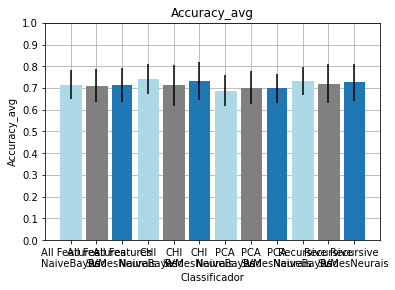

In [58]:

df = concatenar_model.sort_values(by=['dataSet'])
df['Parametros'] = df[['dataSet','Classifier']].fillna('').apply(lambda x: '\n'.join((x).astype(str)), axis=1)
df['Parametros']

conf = [df['accuracy_ic_sup'].array , df['accuracy_ic_inf'].array]
means = df['accuracy_avg'].array
ic = [conf[0]-means , means-conf[1]]


g = plt.bar(df['Parametros'].array, df['accuracy_avg'].array, yerr=ic,width=0.8,zorder=2,align='center')
plt.grid()

g[0].set_color('lightblue')
g[3].set_color('lightblue')
g[6].set_color('lightblue')
g[9].set_color('lightblue')
g[1].set_color('grey')
g[4].set_color('grey')
g[7].set_color('grey')
g[10].set_color('grey')

plt.title("Accuracy_avg")
plt.ylabel('Accuracy_avg')
plt.xlabel('Classificador')
plt.yticks(np.arange(0, 1.1, .1))
plt.rcParams["figure.figsize"] = (16,16)
plt.show()

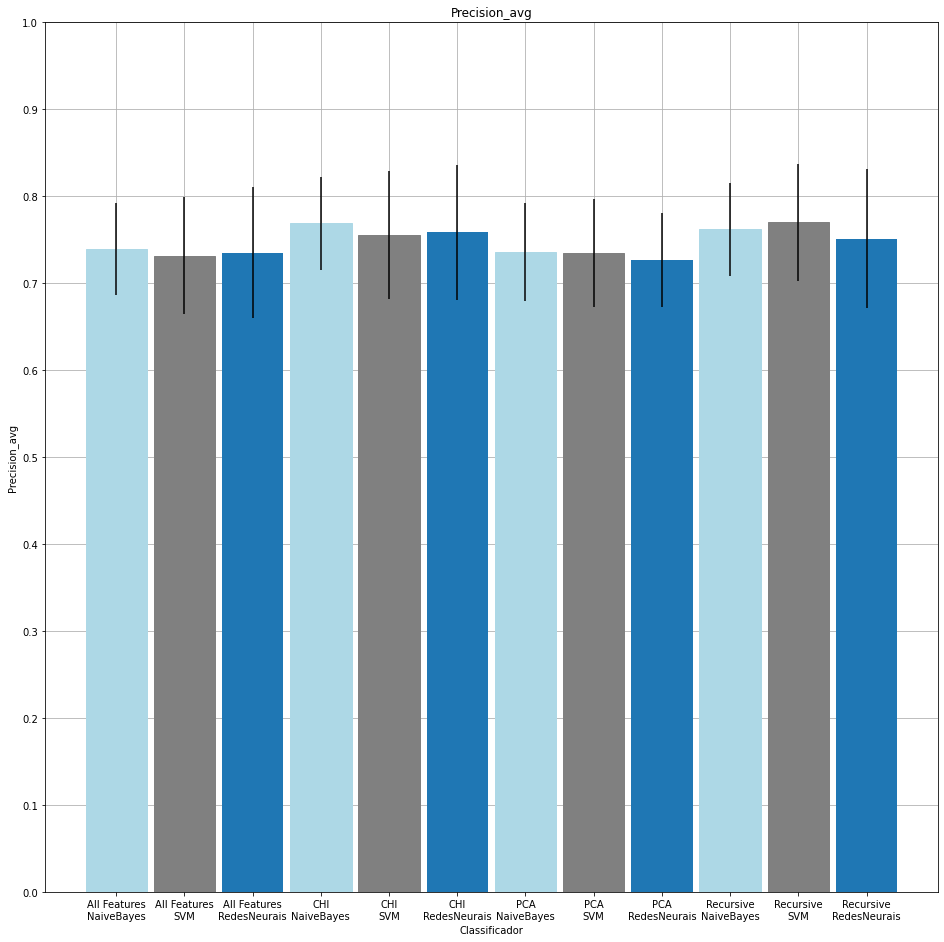

In [59]:
df['Parametros'] = df[['dataSet','Classifier']].fillna('').apply(lambda x: '\n'.join((x).astype(str)), axis=1)
conf = [df['precision_ic_sup'].array , df['precision_ic_inf'].array]
means = df['precision_avg'].array
ic = [conf[0]-means , means-conf[1]]
g = plt.bar(df['Parametros'].array, df['precision_avg'].array, yerr=ic,width=0.9,zorder=2)
plt.grid()

g[0].set_color('lightblue')
g[3].set_color('lightblue')
g[6].set_color('lightblue')
g[9].set_color('lightblue')
g[1].set_color('grey')
g[4].set_color('grey')
g[7].set_color('grey')
g[10].set_color('grey')

plt.title("Precision_avg")
plt.ylabel('Precision_avg')
plt.xlabel('Classificador')
plt.yticks(np.arange(0, 1.1, .1))
plt.rcParams["figure.figsize"] = (16,16)
plt.show()

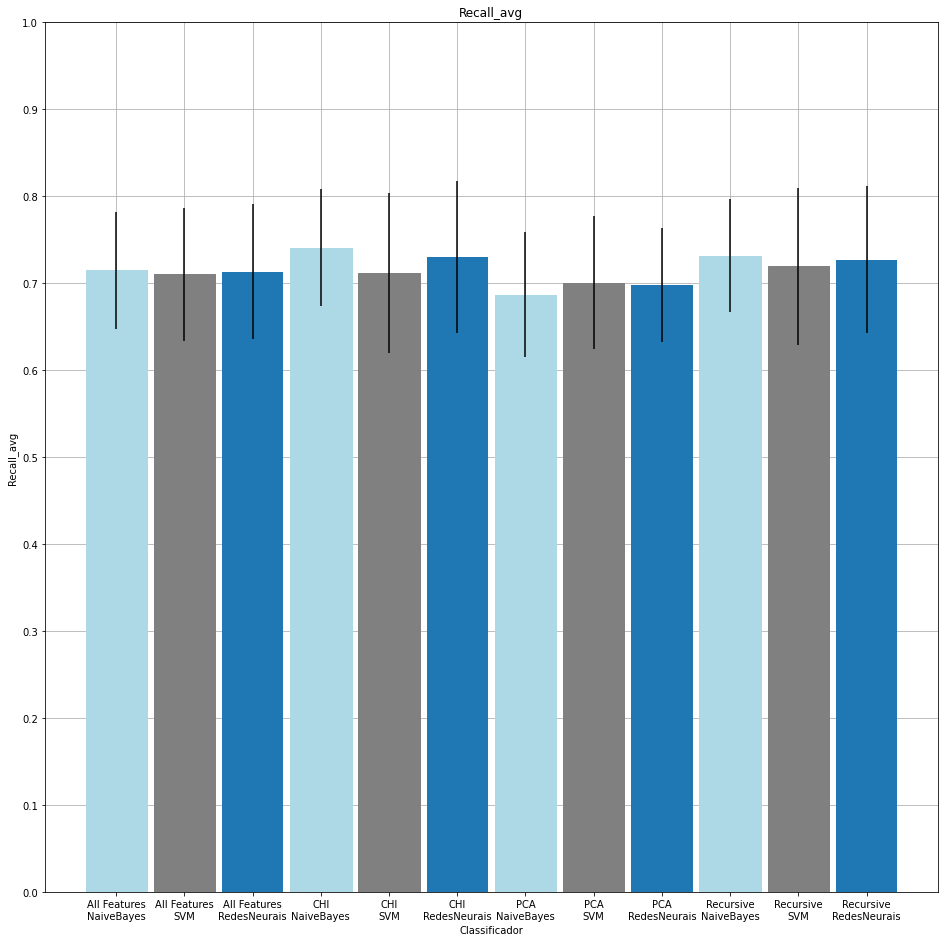

In [60]:
df['Parametros'] = df[['dataSet','Classifier']].fillna('').apply(lambda x: '\n'.join((x).astype(str)), axis=1)
conf = [df['recall_ic_sup'].array , df['recall_ic_inf'].array]
means = df['recall_avg'].array
ic = [conf[0]-means , means-conf[1]]
g = plt.bar(df['Parametros'].array, df['recall_avg'].array, yerr=ic,width=0.9,zorder=2)
plt.grid()

g[0].set_color('lightblue')
g[3].set_color('lightblue')
g[6].set_color('lightblue')
g[9].set_color('lightblue')
g[1].set_color('grey')
g[4].set_color('grey')
g[7].set_color('grey')
g[10].set_color('grey')

plt.title("Recall_avg")
plt.ylabel('Recall_avg')
plt.xlabel('Classificador')
plt.yticks(np.arange(0, 1.1, .1))
plt.rcParams["figure.figsize"] = (16,16)
plt.show()